<a href="https://colab.research.google.com/github/olivia-sp/study-pjt/blob/main/CRAFT_license_plate_data_fine_tuning_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CRAFT License Plate Detection Fine-Tuning
1.   get_licenseplate_detector_dataset 라는 licnese plate detection data에 대한 정보를 return하는 함수를 새로 작성 (Reference : https://github.com/faustomorales/keras-ocr/blob/master/keras_ocr/datasets.py#L178 )
2.   license plate detector 데이터셋에 맞게 CRAFT 파라미터 Fine-Tuning

##환경설정

In [2]:
# Install this package to use Colab's GPU for training
!apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Fetched 420 MB in 7s (62.3 MB/s)
(Reading database ... 123942 files and directories currently installed.)
Removing libcudnn8-dev (8.1.1.33-1+cuda11.2) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
(Reading database ... 123919 files and directories currently installed.)
Preparing to unpack .../libcudnn8_8.4.1.50-1+cuda11.6_amd64.deb ...
Unpacking libcudnn8 (8.4.1.50-1+cuda11.6) over (8.1.1.33-1+cuda11.2) ...
Setting up libcudnn8 (8.4.1.50-1+cuda11.6) ...


In [3]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# Clear any logs from previous runs
!rm -rf ./logs/ 

In [5]:
!pip install keras-ocr

In [6]:
!pip install opencv-python-headless

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Training을 위한 기존 데이터셋 다운로드

license_plate_dataset
- Reference : https://drive.google.com/file/d/1gvD8rsMNFGtu1VxKTwz3_2tQrhE8d9SV/view?usp=sharing

In [7]:
data_dir = '.'

import os
import math
import imgaug
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import tensorflow as tf

import keras_ocr

dataset = keras_ocr.datasets.get_icdar_2013_detector_dataset(
    cache_dir='.',
    skip_illegible=False
)

Looking for ./icdar2013/Challenge2_Training_Task12_Images.zip
Looking for ./icdar2013/Challenge2_Training_Task2_GT.zip


In [6]:
dataset

[('./icdar2013/Challenge2_Training_Task12_Images/303.jpg',
  [[(array([[1198, 1212],
            [1330, 1212],
            [1330, 1339],
            [1198, 1339]]), 'p'), (array([[1341, 1211],
            [1418, 1211],
            [1418, 1301],
            [1341, 1301]]), 'r'), (array([[1428, 1179],
            [1467, 1179],
            [1467, 1300],
            [1428, 1300]]), 'i'), (array([[1474, 1210],
            [1595, 1210],
            [1595, 1300],
            [1474, 1300]]), 'v'), (array([[1600, 1179],
            [1639, 1179],
            [1639, 1299],
            [1600, 1299]]), 'i'), (array([[1652, 1178],
            [1691, 1178],
            [1691, 1298],
            [1652, 1298]]), 'l'), (array([[1705, 1209],
            [1827, 1209],
            [1827, 1298],
            [1705, 1298]]), 'e'), (array([[1840, 1209],
            [1964, 1209],
            [1964, 1333],
            [1840, 1333]]), 'g')], [(array([[2038, 1177],
            [2125, 1177],
            [2125, 1296

In [8]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

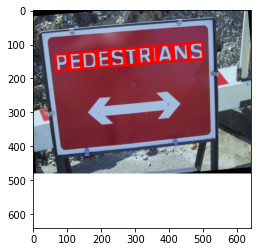

In [9]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [ ]:
# detector = keras_ocr.detection.Detector()

# batch_size = 1
# training_generator, validation_generator = [
#     detector.get_batch_generator(
#         image_generator=image_generator, batch_size=batch_size
#     ) for image_generator in
#     [training_image_generator, validation_image_generator]
# ]
# detector.model.fit_generator(
#     generator=training_generator,
#     steps_per_epoch=math.ceil(len(train) / batch_size),
#     epochs=1000,
#     workers=0,
#     callbacks=[
#         tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
#         tf.keras.callbacks.CSVLogger(os.path.join(data_dir, 'detector_icdar2013.csv')),
#         tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(data_dir, 'detector_icdar2013.h5'))
#     ],
#     validation_data=validation_generator,
#     validation_steps=math.ceil(len(validation) / batch_size)
# )

##커스텀 데이터셋 리턴 포맷 맞추기
###리턴 타입 분석

In [10]:
type(dataset)

list

In [18]:
type(dataset[0][1][0][0])

tuple

In [16]:
dataset[0][1][0][0][0]

array([[1198, 1212],
       [1330, 1212],
       [1330, 1339],
       [1198, 1339]])

In [17]:
type(dataset[0][1][0][0][0])

numpy.ndarray

In [19]:
dataset[0][1][0][0][0].shape

(4, 2)

###커스텀데이터 다운로드

In [8]:
import os
import zipfile
import glob

CURR_PATH = os.getcwd()

os.listdir(CURR_PATH)
CUS_DATA_PATH = CURR_PATH + '/drive/MyDrive/Colab Notebooks/data_set/license_plate_detection_data.zip'
print("RAW_PATH", CUS_DATA_PATH)

with zipfile.ZipFile(CUS_DATA_PATH) as zfile:
  zfile.extractall(CURR_PATH)

RAW_PATH /content/drive/MyDrive/Colab Notebooks/data_set/license_plate_detection_data.zip


###커스텀 데이터 전처리
####keras-ocr(get_icdar_2013_detector_dataset 함수)참고

In [ ]:
# #기존 데이터셋 가져오는 함수 수정 필요
# def get_icdar_2013_detector_dataset(cache_dir=None, skip_illegible=False):
#     """Get the ICDAR 2013 text segmentation dataset for detector
#     training. Only the training set has the necessary annotations.
#     For the test set, only segmentation maps are provided, which
#     do not provide the necessary information for affinity scores.
#     Args:
#         cache_dir: The directory in which to store the data.
#         skip_illegible: Whether to skip illegible characters.
#     Returns:
#         Lists of (image_path, lines, confidence) tuples. Confidence
#         is always 1 for this dataset. We record confidence to allow
#         for future support for weakly supervised cases.
#     """
#     if cache_dir is None:
#         cache_dir = tools.get_default_cache_dir()
#     main_dir = os.path.join(cache_dir, "icdar2013")
#     training_images_dir = os.path.join(main_dir, "Challenge2_Training_Task12_Images")
    
# 		#데이터셋 이미지 압축파일 주소 설정
# 		training_zip_images_path = tools.download_and_verify(
#         url="https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/Challenge2_Training_Task12_Images.zip",  # pylint: disable=line-too-long
#         cache_dir=main_dir,
#         filename="Challenge2_Training_Task12_Images.zip",
#         sha256="7a57d1699fbb92db3ad82c930202938562edaf72e1c422ddd923860d8ace8ded",
#     )
		
# 		#데이터셋 이미지 압축 풀어서 229개 이미지 jpg 가져오기
#     if len(glob.glob(os.path.join(training_images_dir, "*.jpg"))) != 229:
#         with zipfile.ZipFile(training_zip_images_path) as zfile:
#             zfile.extractall(training_images_dir)

# 		#데이터셋 라벨 압축파일 주소 설정
#     training_gt_dir = os.path.join(main_dir, "Challenge2_Training_Task2_GT")
    
# 		#데이터셋 라벨 압축 풀어서 라벨데이터 txt 가져오기
# 		training_zip_gt_path = tools.download_and_verify(
#         url="https://github.com/faustomorales/keras-ocr/releases/download/v0.8.4/Challenge2_Training_Task2_GT.zip",  # pylint: disable=line-too-long
#         cache_dir=main_dir,
#         filename="Challenge2_Training_Task2_GT.zip",
#         sha256="4cedd5b1e33dc4354058f5967221ac85dbdf91a99b30f3ab1ecdf42786a9d027",
#     )
#     if len(glob.glob(os.path.join(training_gt_dir, "*.txt"))) != 229:
#         with zipfile.ZipFile(training_zip_gt_path) as zfile:
#             zfile.extractall(training_gt_dir)


#     dataset = []
#     for gt_filepath in glob.glob(os.path.join(training_gt_dir, "*.txt")):
#         image_id = os.path.split(gt_filepath)[1].split("_")[0]
#         image_path = os.path.join(training_images_dir, image_id + ".jpg")
#         lines = []
#         with open(gt_filepath, "r", encoding="utf8") as f:
#             current_line: typing.List[typing.Tuple[np.ndarray, str]] = []
#             for raw_row in f.read().split("\n"):
#                 if raw_row == "":
#                     lines.append(current_line)
#                     current_line = []
#                 else:
#                     row = raw_row.split(" ")[5:]
#                     character = row[-1][1:-1]
#                     if character == "" and skip_illegible:
#                         continue
#                     x1, y1, x2, y2 = map(int, row[:4])
#                     current_line.append(
#                         (np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]]), character)
#                     )
#         # Some lines only have illegible characters and if skip_illegible is True,
#         # then these lines will be blank.
#         lines = [line for line in lines if line]
				
# 				#이미지 패스, 좌표값, 1(정답) 리턴
#         dataset.append((image_path, lines, 1))
#     return dataset

In [ ]:
"""
ICDAR2013 데이터셋
array([[1198, 1212],
       [1330, 1212],
       [1330, 1339],
       [1198, 1339]])

license_plate_detection 데이터셋
335 294 448 294 448 350 335 350 "TVG399"
->
array([[335, 294],
       [448, 294],
       [448, 350],
       [335, 350]])
"""

In [9]:
def get_licenseplate_detector_dataset(current_dir=None):
  
  if current_dir is None:
    return ValueError('current_dir is None')

  main_dir = os.path.join(current_dir, 'license_plate_detection_data')
  training_images_dir = os.path.join(main_dir, "images")
  training_annot_dir = os.path.join(main_dir, "annotations")
	
  dataset = []

  for gt_list in glob.glob(os.path.join(training_annot_dir, '*.txt')):
    #print(gt_list)
    image_id = gt_list.split('/')[-1].split('.')[0]
    image_path = os.path.join(training_images_dir, image_id + '.jpg')
    #print(image_path)

    lines = []

    with open(gt_list, 'r') as f:
      for row in f.read().split('\n'):
        current_line = []
        character = row.split(' ')[-1][1:-1]
        row = row.split(' ')[:-1]
        
        x1, y1, x2, y2, x3, y3, x4, y4 = map(int, row[:8])
        current_line.append((np.array([[x1, y1], [x2, y2], [x3, y3], [x4, y4]]), character))
        lines.append(current_line)
        # print(lines[0])
    
    #if 조건에 해당하는 값만 출력
    # for line in lines:
    #   if line:
    #     line
    # = line for line in lines if line

    lines = [line for line in lines if line]
    dataset.append((image_path, lines, 1))

  return dataset

In [10]:
dataset = get_licenseplate_detector_dataset(current_dir='/content')
print(dataset[0])

('/content/license_plate_detection_data/images/d4f79480-366a-40b6-ab2c-328bcba705b2.jpg', [[(array([[478, 336],
       [549, 336],
       [549, 371],
       [478, 371]]), 'FB5X8T')]], 1)


## Train 데이터 & Test 데이터 나누기

In [11]:
train, validation = sklearn.model_selection.train_test_split(
    dataset, train_size=0.8, random_state=42
)
augmenter = imgaug.augmenters.Sequential([
    imgaug.augmenters.Affine(
    scale=(1.0, 1.2),
    rotate=(-5, 5)
    ),
    imgaug.augmenters.GaussianBlur(sigma=(0, 0.5)),
    imgaug.augmenters.Multiply((0.8, 1.2), per_channel=0.2)
])
generator_kwargs = {'width': 640, 'height': 640}
training_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=train,
    augmenter=augmenter,
    **generator_kwargs
)
validation_image_generator = keras_ocr.datasets.get_detector_image_generator(
    labels=validation,
    **generator_kwargs
)

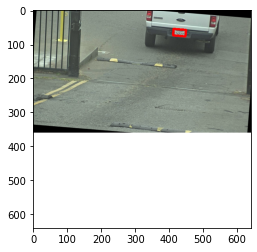

In [12]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

##모델 학습

In [13]:
!pwd

/content


In [14]:
detector = keras_ocr.detection.Detector()

#모델 가중치 저장
#기존에 학습시키던 모델 있으면 학습하는 코드
loading_model_path = os.path.join(CURR_PATH, '/drive/MyDrive/Colab Notebooks/craft_detector_carplate.h5')
if os.path.isfile(loading_model_path) == True:
  detector.model.load_weights(loading_model_path)
  print(loading_model_path + ' model loaded')


Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [94]:
#os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private' # 추가
with tf.device('/device:GPU:0'):
  batch_size = 1
  training_generator, validation_generator = [
      detector.get_batch_generator(
          image_generator=image_generator, batch_size=batch_size
      ) for image_generator in
      [training_image_generator, validation_image_generator]
  ]
  detector.model.fit_generator(
      generator=training_generator,
      steps_per_epoch=math.ceil(len(train) / batch_size),
      epochs=1000,
      workers=0,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
          
          #epoch별 로그변화 csv 파일 저장
          tf.keras.callbacks.CSVLogger(os.path.join(CURR_PATH, 'craft_detector_carplate.csv')),
          #epoch별 현재까지 학습된 모델 저장
          tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(CURR_PATH, 'craft_detector_carplate.h5'))
      ],
      validation_data=validation_generator,
      validation_steps=math.ceil(len(validation) / batch_size)
  )

Epoch 1/1000
  1/177 [..............................] - ETA: 8s - loss: 1.6939e-04

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


177/177 [==============================] - 17s 99ms/step - loss: 2.0792e-04 - val_loss: 0.0024
Epoch 2/1000
177/177 [==============================] - 18s 100ms/step - loss: 2.0708e-04 - val_loss: 0.0014
Epoch 3/1000
177/177 [==============================] - 17s 99ms/step - loss: 2.6218e-04 - val_loss: 0.0011
Epoch 4/1000
177/177 [==============================] - 17s 99ms/step - loss: 3.1637e-04 - val_loss: 5.8329e-04
Epoch 5/1000
177/177 [==============================] - 18s 99ms/step - loss: 3.3705e-04 - val_loss: 5.5797e-04
Epoch 6/1000
177/177 [==============================] - 17s 99ms/step - loss: 2.9562e-04 - val_loss: 6.3473e-04
Epoch 7/1000
177/177 [==============================] - 18s 101ms/step - loss: 3.0136e-04 - val_loss: 4.2900e-04
Epoch 8/1000
177/177 [==============================] - 18s 100ms/step - loss: 3.1263e-04 - val_loss: 5.4431e-04
Epoch 9/1000
177/177 [==============================] - 17s 98ms/step - loss: 2.2976e-04 - val_loss: 4.7252e-04
Epoch 10/1000


###완료 모델(h5) 및 트레이닝 로그 PC 다운로드

In [95]:
#pc 저장
from google.colab import files
files.download('/content/craft_detector_carplate.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [96]:
#pc 저장
files.download('/content/craft_detector_carplate.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

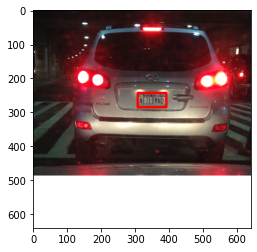

In [17]:
# draw one sample training image for sanity check
image, lines, confidence = next(validation_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

In [15]:
!mkdir craft_license_plate_validation_result

In [16]:
validation

[('/content/license_plate_detection_data/images/wts-lg-000027.jpg',
  [[(array([[ 887,  205],
            [1021,  205],
            [1021,  272],
            [ 887,  272]]), 'SG8L7E')]],
  1),
 ('/content/license_plate_detection_data/images/wts-lg-000068.jpg',
  [[(array([[566, 452],
            [625, 452],
            [625, 481],
            [566, 481]]), 'N359973')]],
  1),
 ('/content/license_plate_detection_data/images/us2.jpg', [[(array([[305, 232],
            [417, 232],
            [417, 288],
            [305, 288]]), 'EUS664')]], 1),
 ('/content/license_plate_detection_data/images/us1.jpg', [[(array([[501, 335],
            [660, 335],
            [660, 414],
            [501, 414]]), '4PCI264')]], 1),
 ('/content/license_plate_detection_data/images/wts-lg-000051.jpg',
  [[(array([[756, 505],
            [854, 505],
            [854, 554],
            [756, 554]]), 'PJ2X1V')]],
  1),
 ('/content/license_plate_detection_data/images/wts-lg-000012.jpg',
  [[(array([[571, 283],
 

### 모델 loadiing

In [17]:
# Previous to this assume you've trained a recognizer.
detector.model.save_weights('/content/drive/MyDrive/Colab Notebooks/craft_detector_carplate.h5')

# Let's reload the recognizer. First, instantiate a recognizer with the *same*
# arguments as those you used earlier (e.g., alphabet).
reloaded_detector = keras_ocr.detection.Detector()

# Now load the weights you saved earlier.
reloaded_detector.model.load_weights('/content/drive/MyDrive/Colab Notebooks/craft_detector_carplate.h5')

Looking for /root/.keras-ocr/craft_mlt_25k.h5


In [21]:
import imageio
import cv2

output_folder = 'craft_license_plate_validation_result'

for image_path, _, _ in validation:
  image = keras_ocr.tools.read(image_path)

  output_image_path = os.path.join(output_folder, image_path.split('/')[-1])

  # detector prediction
  pred_boxes = reloaded_detector.detect(np.expand_dims(image, axis=0))
  #print(pred_boxes)

  for each_pred in pred_boxes[0]:
    left, top = each_pred[0]
    right, bottom = each_pred[2]
    print(left, top, right, bottom)
    canvas = cv2.rectangle(image, (int(left), int(top)), (int(right), int(bottom)), (0,255,0), 3)

  imageio.imwrite(output_image_path, canvas) 
  print(output_image_path + ' saved!' )

1/1 [==============================] - 0s 29ms/step
2.0 4.0 124.0 18.0
1160.4309 126.553856 1199.1694 146.64615
892.0 220.0 950.0 260.0
974.0 224.0 1014.0 264.0
914.0 262.0 954.0 274.0
1210.0 700.0 1252.0 710.0
1222.0 710.0 1258.0 718.0
craft_license_plate_validation_result/wts-lg-000027.jpg saved!
1/1 [==============================] - 0s 23ms/step
4.0 4.0 72.0 18.0
74.0 4.0 124.0 18.0
566.1056 457.5698 623.69434 483.03018
730.0 480.0 778.0 488.0
742.0 490.0 790.0 498.0
craft_license_plate_validation_result/wts-lg-000068.jpg saved!
1/1 [==============================] - 0s 23ms/step
499.61896 214.09158 578.42255 224.98373
308.0 246.0 414.0 278.0
craft_license_plate_validation_result/us2.jpg saved!
1/1 [==============================] - 0s 26ms/step
506.0 360.0 652.0 402.0
992.0 626.0 1070.0 658.0
1070.0 694.0 1106.0 712.0
1108.0 696.0 1244.0 712.0
1242.0 700.0 1276.0 712.0
craft_license_plate_validation_result/us1.jpg saved!
1/1 [==============================] - 0s 26ms/step
4.0 4.0 

In [ ]:
!zip -r /content/craft_license_plate_validation_result.zip /content/craft_license_plate_validation_result

In [112]:
from google.colab import files
files.download("/content/craft_license_plate_validation_result.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Google drive mount

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
